In [1]:
# Binary Classifier implementation (model architecture, training, testing, etc.) derived from
#     https://towardsdatascience.com/pytorch-tabular-binary-classification-a0368da5bb89

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [3]:
# loading subset of training data as per https://www.kaggle.com/sohier/competition-api-detailed-introduction/notebook
train_df = pd.read_csv('data/train.csv', low_memory=False, nrows=10**5, 
                       dtype={'row_id': 'int64', 'timestamp': 'int64', 'user_id': 'int32', 'content_id': 'int16', 'content_type_id': 'int8',
                              'task_container_id': 'int16', 'user_answer': 'int8', 'answered_correctly': 'int8', 'prior_question_elapsed_time': 'float32', 
                             'prior_question_had_explanation': 'boolean',
                             }
                      )

In [4]:
train_df

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,<NA>
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False
...,...,...,...,...,...,...,...,...,...,...
99995,99995,153647401,2078569,4334,0,275,3,0,6000.0,True
99996,99996,153692472,2078569,6436,0,276,3,0,9000.0,True
99997,99997,153722998,2078569,6446,0,277,2,1,21000.0,True
99998,99998,153759775,2078569,3715,0,278,3,0,12000.0,True


In [5]:
# get equal amount of correct and incorrect rows and shuffle data
num_correct_rows = train_df[train_df['answered_correctly'] == 1].shape[0]
num_incorrect_rows = train_df[train_df['answered_correctly'] == 0].shape[0]
num_train_rows = min(num_correct_rows, num_incorrect_rows) * 2

correct_df = train_df[train_df['answered_correctly'] == 1][:num_train_rows // 2]
incorrect_df = train_df[train_df['answered_correctly'] == 0][:num_train_rows // 2]
train_df = pd.concat([correct_df, incorrect_df]).dropna().sample(frac=1)

In [6]:
train_df

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
6840,6840,9936890006,24418,239,0,3792,1,0,17000.0,True
20353,20353,82262699,260489,5250,0,31,1,0,24000.0,True
13410,13410,2819981361,138650,8065,0,234,2,1,50800.0,True
67423,67423,20875545441,1440282,9170,0,3751,0,0,24000.0,True
28562,28562,610657,583550,8772,0,22,0,0,10000.0,True
...,...,...,...,...,...,...,...,...,...,...
38706,38706,8259930021,1084314,837,0,487,3,1,18000.0,True
34544,34544,60769083,934487,6463,0,17,0,1,12000.0,True
7219,7219,10878150882,24418,1111,0,4080,3,1,18000.0,True
21340,21340,63446,327181,1278,0,3,0,0,21000.0,False


In [7]:
X = train_df.iloc[:, np.r_[2:7, 8:10]]
y = train_df.iloc[:, 7]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [9]:
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [10]:
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()

        self.layer_1 = nn.Linear(7, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = BinaryClassifier()
model.to(device)

BinaryClassifier(
  (layer_1): Linear(in_features=7, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
)

In [12]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [13]:
class TrainDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

train_data = TrainDataset(torch.FloatTensor(np.array(X_train.values, dtype=np.float64)), 
                          torch.FloatTensor(y_train.values))

In [14]:
class TestDataset(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = TestDataset(torch.FloatTensor(np.array(X_test.values, dtype=np.float64)))

In [15]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [16]:
# calculates accuracy given predictions and labels
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [17]:
model.train()
epoch_losses = []
for e in range(1, EPOCHS + 1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)

        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    epoch_losses.append(epoch_loss / len(train_loader)) 

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 318.71336 | Acc: 56.130
Epoch 002: | Loss: 1.29016 | Acc: 61.101
Epoch 003: | Loss: 0.62299 | Acc: 64.986
Epoch 004: | Loss: 0.60057 | Acc: 66.312
Epoch 005: | Loss: 0.59979 | Acc: 66.675
Epoch 006: | Loss: 0.59623 | Acc: 67.379
Epoch 007: | Loss: 0.59247 | Acc: 67.502
Epoch 008: | Loss: 0.60418 | Acc: 66.829
Epoch 009: | Loss: 0.61191 | Acc: 65.744
Epoch 010: | Loss: 0.70269 | Acc: 50.863
Epoch 011: | Loss: 0.68519 | Acc: 53.792
Epoch 012: | Loss: 0.68092 | Acc: 57.918
Epoch 013: | Loss: 0.68815 | Acc: 54.014
Epoch 014: | Loss: 0.69056 | Acc: 53.480
Epoch 015: | Loss: 0.69320 | Acc: 49.871
Epoch 016: | Loss: 0.69314 | Acc: 50.202
Epoch 017: | Loss: 0.69315 | Acc: 49.840
Epoch 018: | Loss: 0.69318 | Acc: 50.016
Epoch 019: | Loss: 0.69313 | Acc: 49.887
Epoch 020: | Loss: 0.69313 | Acc: 49.651
Epoch 021: | Loss: 0.69314 | Acc: 49.755
Epoch 022: | Loss: 0.69313 | Acc: 50.045
Epoch 023: | Loss: 0.69314 | Acc: 49.870
Epoch 024: | Loss: 0.70306 | Acc: 49.991
Epoch 025: | L

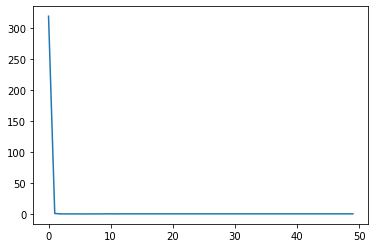

In [18]:
plt.plot(epoch_losses)

In [19]:
# get predictions for test data
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [20]:
# get performance on test data
print(confusion_matrix(y_test, y_pred_list))
print(classification_report(y_test, y_pred_list))

[[    0 10187]
 [    0 10095]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10187
           1       0.50      1.00      0.66     10095

    accuracy                           0.50     20282
   macro avg       0.25      0.50      0.33     20282
weighted avg       0.25      0.50      0.33     20282



/home/rishi/anaconda3/envs/dl/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
